# COMP5310 Assignment 1 Project Stage I Code

Lecturer:  Dr Ali Anaissi 

Group members name and SID:

1. Dinh Nguyen Minh Dang     490457041
2. Mengting (Timi) YE        460250027


================================================================================================================

## Database connection

In [1]:
import psycopg2

def pgconnect():
    YOUR_PW = 'minhdang504'
    try: 
        conn = psycopg2.connect(host='localhost',
                                database='postgres',
                                user='postgres',
                                port= 5433,
                                password=YOUR_PW)
        print('connected')
    except Exception as e:
        print("unable to connect to the database")
        print(e)
    return conn

/anaconda3/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


## Query and Execute Functions

In [2]:
import psycopg2.extras

def pgquery( conn, sqlcmd, args, silent=False, returntype='tuple'):
   """ utility function to execute some SQL query statement
       it can take optional arguments (as a dictionary) to fill in for placeholder in the SQL
       will return the complete query result as return value - or in case of error: None
       error and transaction handling built-in (by using the 'with' clauses) """
   retval = None
   with conn:
      cursortype = None if returntype != 'dict' else psycopg2.extras.RealDictCursor     
      with conn.cursor(cursor_factory=cursortype) as cur:
         try:
            if args is None:
                cur.execute(sqlcmd)
            else:
                cur.execute(sqlcmd, args)
            retval = cur.fetchall() # we use fetchall() as we expect only _small_ query results
         except Exception as e:
            if e.pgcode != None and not(silent):
                print("db read error: ")
                print(e)
   return retval

def pgexec( conn, sqlcmd, args, msg, silent=False ):
   """ utility function to execute some SQL statement
       can take optional arguments to fill in (dictionary)
       error and transaction handling built-in """
   retval = False
   with conn:
      with conn.cursor() as cur:
         try:
            if args is None:
               cur.execute(sqlcmd)
            else:
               cur.execute(sqlcmd, args)
            if silent == False: 
                print("success: " + msg)
            retval = True
         except Exception as e:
            if silent == False: 
                print("db error: ")
                print(e)
   return retval

## Creating table

In [3]:
conn = pgconnect()

pgexec (conn, "DROP TABLE IF EXISTS Melbourne CASCADE", None, "Reset Table Melbourne")

schema = """CREATE TABLE IF NOT EXISTS Melbourne (
                         date DATE,
                         rooms INT,
                         type INT,
                         price FLOAT,
                         distance FLOAT,
                         bedroom FLOAT,
                         bathroom FLOAT,
                         car FLOAT,
                         landsize FLOAT,
                         buildingarea FLOAT,
                         yearbuilt FLOAT,
                         lattitude FLOAT,
                         longtitude FLOAT,
                         propertycount FLOAT
                   )"""
pgexec (conn, schema, None, "Create Table Melbourne")

connected
success: Reset Table Melbourne
success: Create Table Melbourne


True

## Clean function

In [4]:
import numpy as np
DEFAULT_VALUE = np.nan
import csv
import pprint

data = list(csv.DictReader(open('mel.csv')))

#br - bedroom(s); 
#h - house,cottage,villa, semi, terrace;
#u - unit, duplex; 
#t - townhouse; 
#dev site - development site;
#o res - other residential
def clean(data, column_key, convert_function, default_value):
    special_values= {'br': 1, 'h': 2, 'u': 3, 't': 4, 'dev site': 5, 'o': 6} 
    for row in data:
        old_value = row[column_key]
        new_value = default_value
        try:
            if old_value in special_values.keys():
                new_value = special_values[old_value]
            else:
                new_value = convert_function(old_value)
        except (ValueError, TypeError):
            test = 1
            print('Replacing {} with {} in column {}'.format(row[column_key], new_value, column_key))
        row[column_key] = new_value

## Date converting function

In [5]:
from datetime import datetime

FMT = "%d/%m/%Y"

def str_to_time(s):
    if isinstance(s, datetime):
        return s
    return datetime.strptime(s, FMT)

## Cleaning the dataset

In [ ]:
clean(data, 'Rooms', int, DEFAULT_VALUE)
clean(data, 'Price', int, DEFAULT_VALUE)
clean(data, 'Distance', float, DEFAULT_VALUE)
clean(data, 'Bedroom2', int, DEFAULT_VALUE)
clean(data, 'Bathroom', int, DEFAULT_VALUE)
clean(data, 'Car', int, DEFAULT_VALUE)
clean(data, 'Landsize', float, DEFAULT_VALUE)
clean(data, 'BuildingArea', float, DEFAULT_VALUE)
clean(data, 'YearBuilt', int, DEFAULT_VALUE)
clean(data, 'Lattitude', float, DEFAULT_VALUE)
clean(data, 'Longtitude', float, DEFAULT_VALUE)
clean(data, 'Propertycount', int, DEFAULT_VALUE)
clean(data, 'Type', int, DEFAULT_VALUE)
clean(data, 'Date', str_to_time, DEFAULT_VALUE)


## Adding cleaned tuples into database

In [ ]:
# make sure we are still connected to database 
conn = pgconnect()

insert_stmt = """
INSERT INTO Melbourne (
                     date,
                     rooms,
                     type,
                     price,
                     distance,     
                     bedroom,
                     bathroom,
                     car,
                     landsize,
                     buildingarea,
                     yearbuilt,
                     lattitude,
                     longtitude,
                     propertycount)
VALUES (
%(Date)s,%(Rooms)s,%(Type)s,%(Price)s,%(Distance)s,
%(Bedroom2)s,%(Bathroom)s,%(Car)s,%(Landsize)s,
%(BuildingArea)s,%(YearBuilt)s,%(Lattitude)s,
%(Longtitude)s,%(Propertycount)s
                 )
              """
temp = dict()
cols = ['Rooms', 'Type', 'Price', 'Distance', 'Bedroom2', 'Bathroom', 'Car',
        'Landsize', 'BuildingArea', 'YearBuilt', 'Lattitude', 'Longtitude', 'Propertycount']
for row in data:
    flag = True
    for i in range(len(cols)):
        if (np.isnan(row[cols[i]])):
            flag = False
    if flag == True:
        temp['Date'] = row['Date'].strftime('%Y-%m-%d')
        temp['Rooms'] = row['Rooms']
        temp['Type']  = row['Type']
        temp['Price'] = row['Price']
        temp['Distance'] = row['Distance']
        temp['Bedroom2'] = row['Bedroom2']
        temp['Bathroom'] = row['Bathroom']
        temp['Car'] = row['Car']
        temp['Landsize']  = row['Landsize']
        temp['BuildingArea'] = row['BuildingArea']
        temp['YearBuilt'] = row['YearBuilt']
        temp['Lattitude'] = row['Lattitude']
        temp['Longtitude']  = row['Longtitude']
        temp['Propertycount'] = row['Propertycount']
        #pprint.pprint(temp)
        pgexec (conn, insert_stmt, temp, "Row inserted")


# check content of Measurement table
query_stmt = "SELECT * FROM Melbourne limit 20"
print(query_stmt)
pgquery (conn, query_stmt, None)

query_stmt = "SELECT count(*) FROM Melbourne"
print(query_stmt)
pgquery (conn, query_stmt, None)
conn.close();

## Query data from DB for descriptive analysis
### Including data description and correlation matrix

In [8]:
# connect to your database
conn = pgconnect()
    
# prepare SQL statement
query_stmt ="""SELECT * FROM Melbourne;"""
# execute query and print result
query_result = pgquery (conn, query_stmt, None, returntype='dict')
# cleanup
conn.close()

import pandas as pd
from pandas import set_option
dataset = pd.DataFrame(query_result)

# shape
print(dataset.shape)
# types
#print(dataset.dtypes)

# descriptions, change precision to 2 places
set_option('precision', 1)
print("\nDescription:\n", dataset.describe())
# correlation
set_option('precision', 3)
print("\nCorrelation:\n", dataset.corr(method='pearson'))

connected
(8887, 14)

Description:
        bathroom  bedroom  buildingarea     car  distance  landsize  lattitude  \
count    8887.0   8887.0        8887.0  8887.0    8887.0    8887.0    8.9e+03   
mean        1.6      3.1         149.3     1.7      11.2     523.5   -3.8e+01   
std         0.7      1.0          87.9     1.0       6.8    1061.3    9.1e-02   
min         1.0      0.0           0.0     0.0       0.0       0.0   -3.8e+01   
25%         1.0      2.0         100.0     1.0       6.4     212.0   -3.8e+01   
50%         2.0      3.0         132.0     2.0      10.2     478.0   -3.8e+01   
75%         2.0      4.0         180.0     2.0      13.9     652.0   -3.8e+01   
max         9.0     12.0        3112.0    10.0      47.4   42800.0   -3.7e+01   

       longtitude    price  propertycount   rooms    type  yearbuilt  
count      8887.0  8.9e+03         8887.0  8887.0  8887.0     8887.0  
mean        145.0  1.1e+06         7475.9     3.1     2.3     1965.8  
std           0.1  6.

## Histogram for all attributes

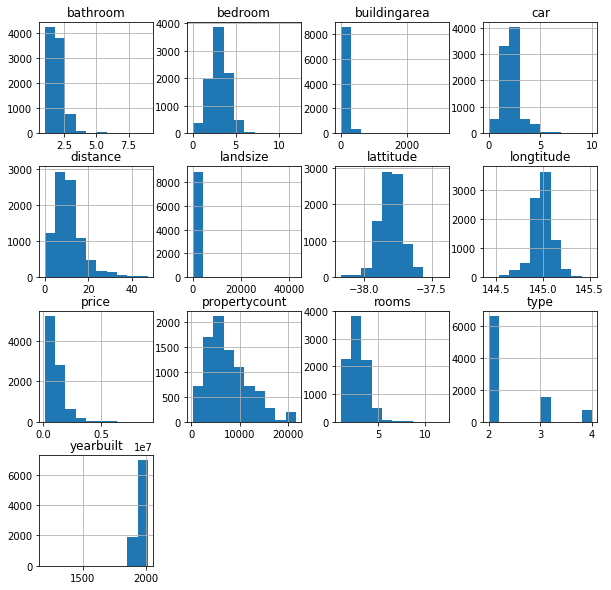

In [16]:
# Data visualizations
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
from numpy import arange

names = ['Rooms', 'Type', 'Price', 'Distance', 'Bedroom2', 'Bathroom', 'Car',
        'Landsize', 'BuildingArea', 'YearBuilt', 'Lattitude', 'Longtitude', 'Propertycount']

# histograms
dataset.hist(figsize=(10,10))
pyplot.show()

## Density plot for all atrributes

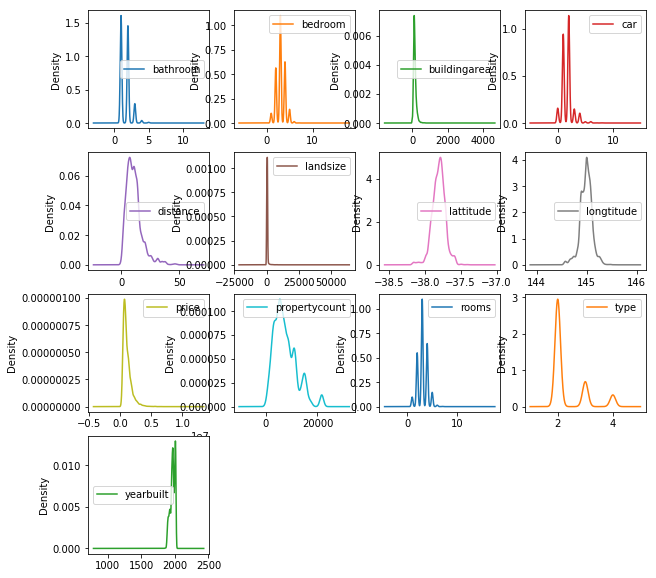

In [10]:
# density
dataset.plot(kind='density', subplots=True, layout=(4,4), figsize=(10,10), sharex=False)
pyplot.show()

## Box and whisker plots

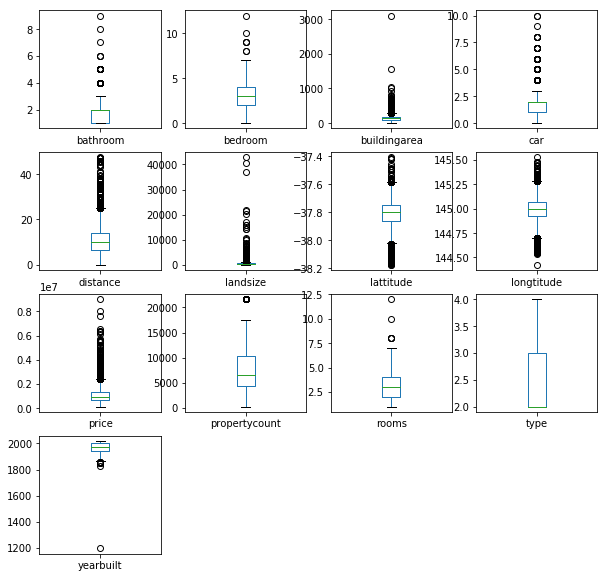

In [11]:
# box and whisker plots
dataset.plot(kind='box', subplots=True, layout=(4,4), figsize=(10,10), sharex=False, sharey=False)
pyplot.show()

## Correlation Matrix visualization

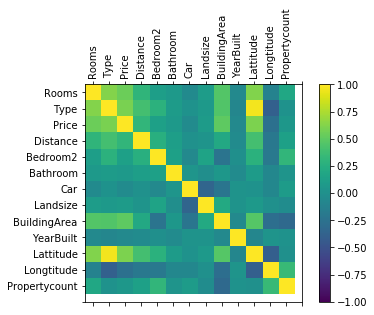

In [12]:
# correlation matrix
fig = pyplot.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(dataset.corr(), vmin=-1, vmax=1, interpolation='none')
fig.colorbar(cax)
ticks = arange(0,14,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names, rotation='vertical')
ax.set_yticklabels(names)
pyplot.show()

## Scatter Plot function

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def make_plot(data, x_key, y_key, title, xlabel=None, ylabel=None, bar_width=0.5, categorical=True):
    xlabel = xlabel or x_key
    ylabel = ylabel or y_key
    xs = [row[x_key] for row in data]
    ys = [row[y_key] for row in data]
    
    if categorical:
        plt.bar(range(len(data)), ys, width=bar_width)
        plt.xticks(np.arange(len(data))+bar_width/2., xs)
    else:
        plt.figure(figsize=(10,5))
        plt.scatter(xs, ys)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xticks(rotation = "vertical")
    plt.xlabel(xlabel)
    plt.show()

## DB query for date and price + plot

connected


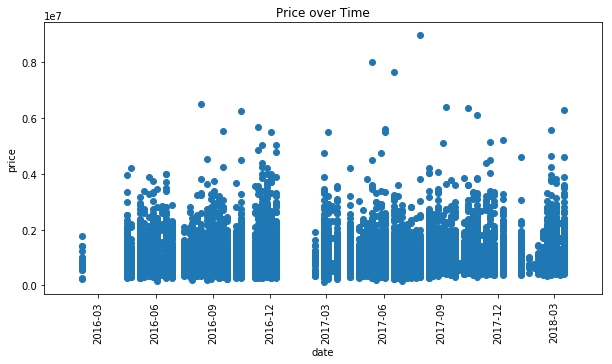

In [14]:
# connect to your database

conn = pgconnect()
    
# prepare SQL statement
query_stmt ="""SELECT date, price FROM Melbourne order by date;"""
# execute query and print result
query_result = pgquery (conn, query_stmt, None, returntype='dict')

make_plot(
    query_result,
    x_key='date',
    y_key='price',
    title='Price over Time',
    categorical=False)

## DB query for distance and price + plot

connected


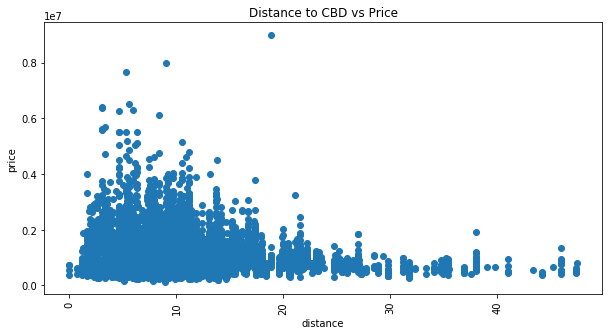

In [15]:
# connect to your database

conn = pgconnect()
    
# prepare SQL statement
query_stmt ="""SELECT distance, price FROM Melbourne;"""
# execute query and print result
query_result = pgquery (conn, query_stmt, None, returntype='dict')

make_plot(
    query_result,
    x_key='distance',
    y_key='price',
    title='Distance to CBD vs Price',
    categorical=False)

## The end. Thanks!